# CATHODE Walkthrough

This is a simple conceptual guide through how the [CATHODE method](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.106.055006) for anomaly detection works. The notebook is oversimplified such that it does not make use of all optimization measures implemented in the main paper. It rather shows the core concept while hiding the technical implementation details behind a scikit-learn style API.

The core assumption of CATHODE is that you have a resonant feature $m$, in which a potential (a-priori unknown) signal process is localized. Furthermore, we want to make use of extra dimensions, our auxiliary features $x$, to discriminate between such a signal and the background. This is illustrated below.

![resonant anomaly detection](images/resonant_anomaly_detection.png)

We would now like to train a neural network classifier in a data-driven manner, such that it learns to classify signal from background. For this aim, we first divide the $m$ spectrum into a signal region (SR), in which we want to look for a localized signal, and the complementary sidebands (SB).

Then we train a conditional normalizing flow to learn the background distribution in $x$ as a function of $m$ from the SB and interpolate into the SR. Sampling from this model will yield an in-situ simulation of just the background.

Finally, we train our classifier to distinguish between the actual data in SR from this learned background template. If there is indeed signal, and it (over-)populates phase space regions in $x$, then this will be the only difference between the two classes. The classifier will thus learn to assign a higher output score to signal data points. This is an anomaly score that we can select on and it will thus increase the relative fraction of signal over background.

These steps are now illustrated via code below.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import sys
import os

from os.path import exists, join, dirname, realpath
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
from sklearn.pipeline import make_pipeline# Show the plot
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

# adding parent directory to path
parent_dir = dirname(realpath(globals()["_dh"][0]))
sys.path.append(parent_dir)

from sk_cathode.generative_models.conditional_normalizing_flow_pyro import ConditionalNormalizingFlow
from sk_cathode.classifier_models.neural_network_classifier import NeuralNetworkClassifier
from sk_cathode.utils.preprocessing import LogitScaler

/gpfs/dust/maxwell/user/yedechit/micromamba/envs/sk_cathode/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# :sunglasses:
#plt.style.use('dark_background')

We preprocess the input data to extract the conditional feature $m=m_{RSD}$ and five auxiliary features $x= H_{T}, \tau_{ 1},\tau_{ 2},\tau_{ 3},\tau_{ 4}$. Moreover, it divides the $m$ spectrum into SR and SB, and splits the data into training/validation/test sets. The $m$ spectrum is divided into Lower sideband: 1500 ~ 2500 GeV, Signal region: 2500~4000 GeV, Upper sideband: > 4000 GeV

The `all.npy` has bkg, sig1, and sig2 all together shuffled but it has no labels

In [3]:
#loading the input data
data_path = "../../data/black_box3/"
#data = np.load(os.path.join(data_path, "all.npy"))  
#print(f"The event features look like:\n{data[:3]}")

#Loading data
bkg = np.load(os.path.join(data_path, "bkg.npy"))  
sig1 = np.load(os.path.join(data_path, "sig1.npy")) 
sig2 = np.load(os.path.join(data_path, "sig2.npy")) 

#sig = np.vstack([sig1,sig2])
#sig = shuffle(sig, random_state=42)

#creating labels
label0 = np.zeros((bkg.shape[0], 1)) 
label_s1 = np.ones((sig1.shape[0], 1)) 
label_s2 = np.ones((sig2.shape[0], 1)) 

#Adding labels with features 
bkg_labeled = np.hstack((bkg, label0))
sig1_labeled = np.hstack((sig1, label_s1))
sig2_labeled = np.hstack((sig2, label_s2))

print(f"Bkg shape:{bkg_labeled.shape}")
#print(f"The bkg events look like:\n{bkg_labeled[:3]}")
print(f"sig1 shape:{sig1_labeled.shape}")
print(f"sig2 shape:{sig2_labeled.shape}")

Bkg shape:(996800, 7)
sig1 shape:(1200, 7)
sig2 shape:(2000, 7)


In [4]:
#Splitting into train, val and test sets maintaining the proportion of bkg, sig1, sig2
bkg_trainNval, bkg_test = train_test_split(bkg_labeled, test_size=0.33, random_state=42)
sig1_trainNval, sig1_test = train_test_split(sig1_labeled, test_size=0.33, random_state=42)
sig2_trainNval, sig2_test = train_test_split(sig2_labeled, test_size=0.33, random_state=42)

bkg_train, bkg_val = train_test_split(bkg_trainNval, test_size=0.25, random_state=42)
sig1_train, sig1_val = train_test_split(sig1_trainNval, test_size=0.25, random_state=42)
sig2_train, sig2_val = train_test_split(sig2_trainNval, test_size=0.25, random_state=42)

#Combine the sets
data_train = np.vstack([bkg_train, sig1_train, sig2_train])
data_val = np.vstack([bkg_val, sig1_val, sig2_val])
data_test = np.vstack([bkg_test, sig1_test, sig2_test])

#Shuffle
data_train = shuffle(data_train, random_state=42)
data_val = shuffle(data_val, random_state=42)
data_test = shuffle(data_test, random_state=42)

print(data_train.shape)
print(data_val.shape)
print(data_test.shape)

(502500, 7)
(167500, 7)
(330000, 7)


In [5]:
# data preparation

def separate_SB_SR(dataset, minmass, maxmass):
    innermask = (dataset[:, 0] > minmass) & (dataset[:, 0] < maxmass)
    outermask = ~innermask
    return dataset[innermask], dataset[outermask] 

minmass = 2500.0
maxmass = 4000.0

innerdata_train, outerdata_train = separate_SB_SR(data_train, minmass, maxmass)
innerdata_val, outerdata_val = separate_SB_SR(data_val, minmass, maxmass)
innerdata_test, outerdata_test = separate_SB_SR(data_test, minmass, maxmass)

print(innerdata_train.shape)
print(innerdata_val.shape)
print(innerdata_test.shape)
print(outerdata_train.shape)
print(outerdata_val.shape)
print(outerdata_test.shape)

(240645, 7)
(80053, 7)
(157162, 7)
(261855, 7)
(87447, 7)
(172838, 7)


Now the conditional normalizing flow is trained on SB data. Since flows learn a smooth mapping, it is hard for them to learn steep edges. Thus, we first apply a logit transformation to smoothen out the boundaries and then apply a standard scaler transformation to normalize the data to zero mean and unit variance. The flow is then trained on these transformed data.

In [6]:
# either train new flow model from scratch

# We streamline the preprocessing with an sklearn pipeline. 
m_scaler = StandardScaler()
outer_scaler = make_pipeline(LogitScaler(), StandardScaler())

m_train = m_scaler.fit_transform(outerdata_train[:, 0:1])
X_train = outer_scaler.fit_transform(outerdata_train[:, 1:-1])
m_val = m_scaler.transform(outerdata_val[:, 0:1])
X_val = outer_scaler.transform(outerdata_val[:, 1:-1])

print(m_train.shape)
print(X_train.shape)
print(m_val.shape)
print(X_val.shape)
# print(f"X_val:\n{X_val[:4]}")

X_train = np.nan_to_num(X_train, nan=0)  # Replace NaNs with 0
X_val = np.nan_to_num(X_val, nan=0)  # Replace NaNs with 0

#NaN checks
has_nan = np.isnan(X_train).any()
num_nans = np.isnan(X_train).sum()
print(has_nan, num_nans)

#for plotting normalized hists
NF_train = np.hstack((m_train,X_train))
NF_val = np.hstack((m_val,X_val))
print(NF_train.shape)
print(NF_val.shape)

(261855, 1)
(261855, 5)
(87447, 1)
(87447, 5)
False 0
(261855, 6)
(87447, 6)


In [7]:
'''
#QUICK CHECK! input feature plots
def plot_hists(datasets, column_name, title):
    
    for data in datasets:
     print(data.shape) 

    col_names = ['m_RSD', 'HT', 'jettiness_1', 'jettiness_2', 'jettiness_3', 'jettiness_4']
    subplot_titles = ['SB_trainset', 'SB_valset', 'trainset_after scaling', 'Valset_after scaling']
    column_index = col_names.index(column_name)
    
    plt.figure(figsize=(12, 8)) 
    for i, data in enumerate(datasets):
        feature = data[:, column_index]
        
        plt.subplot(2, 2, i + 1)  # 2x2 grid of subplots
        plt.hist(feature, bins=50, color='gray')
        plt.title(subplot_titles[i], fontsize=12)
        plt.xlabel(column_name, fontsize=10)
        plt.ylabel('Events', fontsize=10)


    # Set the overall title for the figure
    plt.suptitle(title, fontsize=14)
    #plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
    plt.tight_layout(pad=2.0)
    plt.show()

plot_hists(
    [outerdata_train, outerdata_val, NF_train, NF_val],
    column_name='m_RSD',
    title='m_RSD'
)
plot_hists(
    [outerdata_train, outerdata_val, NF_train, NF_val],
    column_name='HT',
    title='HT'
)
plot_hists(
    [outerdata_train, outerdata_val, NF_train, NF_val],
    column_name='jettiness_1',
    title=''
)
plot_hists(
    [outerdata_train, outerdata_val, NF_train, NF_val],
    column_name='jettiness_2',
    title=''
)
plot_hists(
    [outerdata_train, outerdata_val, NF_train, NF_val],
    column_name='jettiness_3',
    title=''
)
plot_hists(
    [outerdata_train, outerdata_val, NF_train, NF_val],
    column_name='jettiness_4',
    title=''
)
'''

"\n#QUICK CHECK! input feature plots\ndef plot_hists(datasets, column_name, title):\n    \n    for data in datasets:\n     print(data.shape) \n\n    col_names = ['m_RSD', 'HT', 'jettiness_1', 'jettiness_2', 'jettiness_3', 'jettiness_4']\n    subplot_titles = ['SB_trainset', 'SB_valset', 'trainset_after scaling', 'Valset_after scaling']\n    column_index = col_names.index(column_name)\n    \n    plt.figure(figsize=(12, 8)) \n    for i, data in enumerate(datasets):\n        feature = data[:, column_index]\n        \n        plt.subplot(2, 2, i + 1)  # 2x2 grid of subplots\n        plt.hist(feature, bins=50, color='gray')\n        plt.title(subplot_titles[i], fontsize=12)\n        plt.xlabel(column_name, fontsize=10)\n        plt.ylabel('Events', fontsize=10)\n\n\n    # Set the overall title for the figure\n    plt.suptitle(title, fontsize=14)\n    #plt.tight_layout(rect=[0, 0.03, 1, 0.95]) \n    plt.tight_layout(pad=2.0)\n    plt.show()\n\nplot_hists(\n    [outerdata_train, outerdata_val

In [8]:
flow_savedir = "./trained_flows3/"
# Let's protect ourselves from accidentally overwriting a trained model.
if not exists(join(flow_savedir, "DE_models")):
    flow_model = ConditionalNormalizingFlow(save_path=flow_savedir,
                                            num_inputs=outerdata_train[:, 1:-1].shape[1],
                                            early_stopping=True, epochs=None,
                                            verbose=True)
    flow_model.fit(X_train, m_train, X_val, m_val)
else:
    print(f"The model exists already in {flow_savedir}. Remove first if you want to overwrite.")


The model exists already in ./trained_flows3/. Remove first if you want to overwrite.


In [9]:
'''
flow_savedir = "./trained_flows/"
flow_model = ConditionalNormalizingFlow(save_path=flow_savedir,
                                        num_inputs=outerdata_train[:, 1:].shape[1],
                                        early_stopping=True, epochs=None,
                                        verbose=True)
flow_model.fit(X_train, m_train, X_val, m_val)

log_p = flow_model.predict_log_proba(X_train, m_train)
log_p_val = flow_model.predict_log_proba(X_val, m_val)

print(log_p)
print(log_p_val)
'''

'\nflow_savedir = "./trained_flows/"\nflow_model = ConditionalNormalizingFlow(save_path=flow_savedir,\n                                        num_inputs=outerdata_train[:, 1:].shape[1],\n                                        early_stopping=True, epochs=None,\n                                        verbose=True)\nflow_model.fit(X_train, m_train, X_val, m_val)\n\nlog_p = flow_model.predict_log_proba(X_train, m_train)\nlog_p_val = flow_model.predict_log_proba(X_val, m_val)\n\nprint(log_p)\nprint(log_p_val)\n'

In [10]:
# or loading existing flow model

outer_scaler = make_pipeline(LogitScaler(), StandardScaler())
outer_scaler.fit(outerdata_train[:, 1:-1])

flow_savedir = "./trained_flows3/"
flow_model = ConditionalNormalizingFlow(save_path=flow_savedir,
                                        num_inputs=outerdata_train[:, 1:-1].shape[1],
                                        load=True)
                                        

Normalizing Flow has 32930 parameters


/gpfs/dust/maxwell/user/yedechit/sk_cathode/sk_cathode/generative_models/conditional_normalizing_flow_pyro.py:653: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.l

We now have a trained flow model that samples data in $x$ for given values in $m$. We simply interpolate this SB-trained model into the SR by plugging corresponding $m$ values into the sampling method of the model. However, this requires us to first sample a realistic distribution of SR $m$ values. We do this by learning a simple 1D kernel density estimator (KDE) on $m$ values within the SR. From this KDE model we sample now as many values as we want SR samples. We can in fact sample more background events than we have data, as long as we apply proper weights in the classifier training later.

For the classifier training, we give this learned background template a label of 0.

In [11]:
# fitting a KDE for the mass distribution based on the inner training set

#We found out that KDE fit works better in the logit space
#Just here, we use the Logitscaler on m

# we also perform a logit first to stretch out the hard boundaries
SRm_scaler = LogitScaler(epsilon=1e-8)
SRm_train_KDE = SRm_scaler.fit_transform(innerdata_train[:, 0:1])

kde_model = KernelDensity(bandwidth=0.01, kernel='gaussian')
kde_model.fit(SRm_train_KDE)

# now let's sample 4x the number of training data
SRm_samples = kde_model.sample(4*len(m_train)).astype(np.float32)
SRm_samples = SRm_scaler.inverse_transform(SRm_samples)

print(SRm_samples.shape)
print(f"SRm_samples:\n{SRm_samples[:3]}")


(1047420, 1)
SRm_samples:
[[3279.7646]
 [3124.7014]
 [3158.2644]]


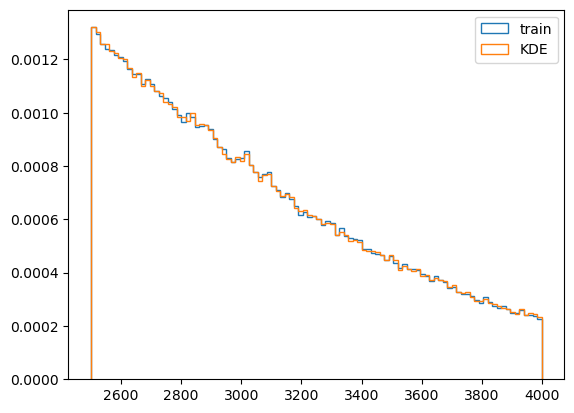

In [12]:
# stupid cell by manuel
_, binning, _ = plt.hist(innerdata_train[:, 0:1], bins=100, histtype="step", label="train", density=True)
plt.hist(SRm_samples, bins=binning, histtype="step", label="KDE", density=True)
plt.legend()
plt.show()

In [13]:
# drawing samples from the flow model with the KDE samples as conditional
#here we again use the stdscaler on m
SRm_samples = m_scaler.transform(SRm_samples)
X_samples = flow_model.sample(n_samples=len(SRm_samples), m=SRm_samples)
print(f"X_samples:\n{X_samples[:3]}")

X_samples = outer_scaler.inverse_transform(X_samples)
SRm_samples = m_scaler.inverse_transform(SRm_samples)

print(X_samples.shape)
print(f"X_samples:\n{X_samples[:3]}")

# assigning "signal" label 0 to samples - this is pure bkg
samples = np.hstack([SRm_samples, X_samples, np.zeros((SRm_samples.shape[0], 1))])
print(f"Samples(pure bkg):\n{samples[:3]}")

X_samples:
[[ 0.10719339  0.20657623  1.5699073  -0.11096988 -0.01372965]
 [ 0.43525046  0.5468509   1.6928372   1.8671564   1.3594202 ]
 [ 0.3920408   0.9211838   1.3152294   1.2238452   1.0950903 ]]
(1047420, 5)
X_samples:
[[2840.6067  4865.459   1971.035    418.9768   331.70563]
 [2958.401   5139.0024  2104.6262  1291.8091   715.2934 ]
 [2942.3245  5453.3853  1709.796    927.80707  623.07153]]
Samples(pure bkg):
[[3279.76464844 2840.60668945 4865.45898438 1971.03503418  418.97680664
   331.70562744    0.        ]
 [3124.70141602 2958.40087891 5139.00244141 2104.6262207  1291.80908203
   715.293396      0.        ]
 [3158.2644043  2942.32446289 5453.38525391 1709.79602051  927.80706787
   623.0715332     0.        ]]


Since in this case we know beforehand which data points are signal and which are background, we can exactly compare the learned background template to the actual background within the (simulated) SR dataset.

(157162, 7)


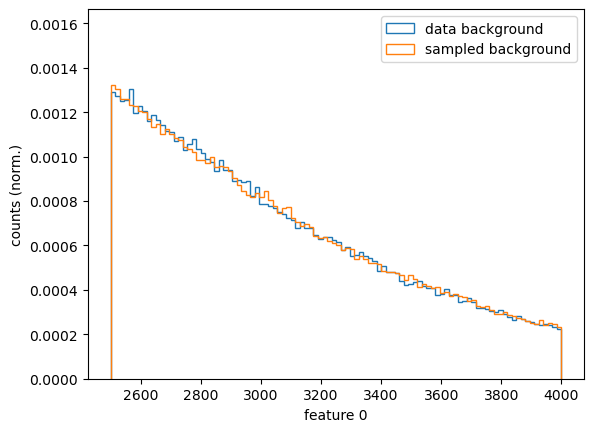

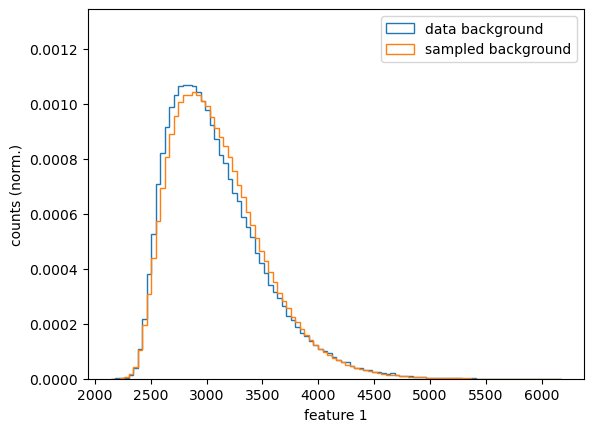

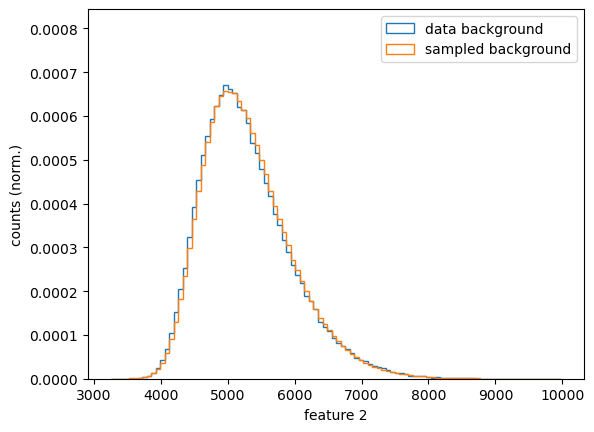

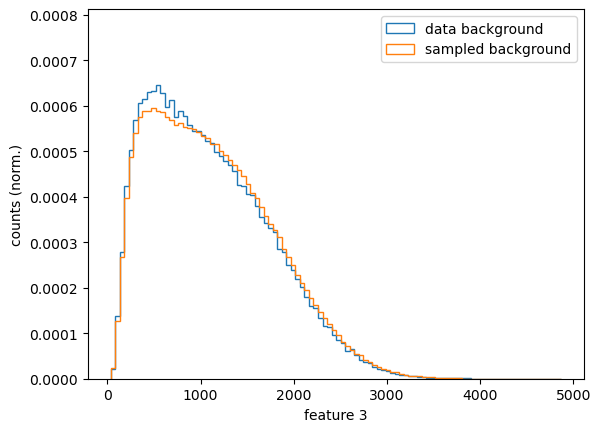

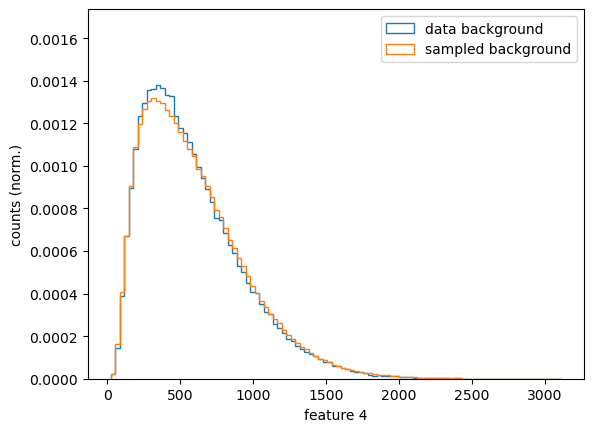

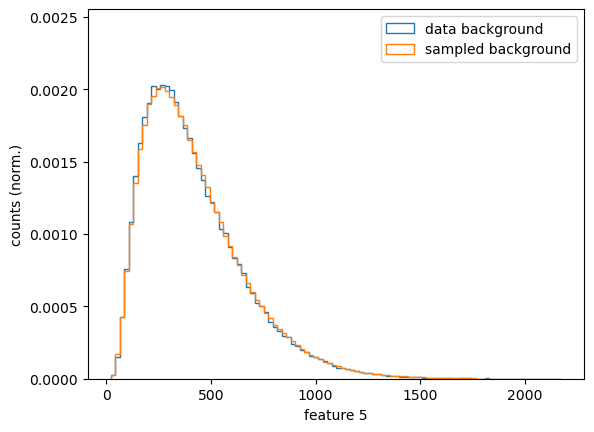

In [14]:
# comparing samples to inner background (idealized sanity check)
print(innerdata_test.shape)


for i in range(innerdata_test[:, :-1].shape[1]):
    _, binning, _ = plt.hist(innerdata_test[innerdata_test[:, -1] == 0, i],
                             bins=100, label="data background",
                             density=True, histtype="step")
    _ = plt.hist(samples[:, i],
                 bins=binning, label="sampled background",
                 density=True, histtype="step")
    plt.legend()
    plt.ylim(0, plt.gca().get_ylim()[1] * 1.2)
    plt.xlabel("feature {}".format(i))
    plt.ylabel("counts (norm.)")
    plt.show()

The entire SR dataset is assigned a label of 1 for the classifier training. Contrary to the standard fully supervised training, where you assign a label of 1 to signal and 0 to background, this so-called weakly supervised learning aims at distinguishing two almost equal samples: the data (background + small signal) from pure background (the learned background template). One can [show](https://link.springer.com/article/10.1007/JHEP10(2017)174) that this training will still (under optimal conditions) yield a classifier that assigns a higher score to signal than to background.

In [15]:
# assigning label 1 to data (bkg+small signal) JUST FOR TRAINING
print(innerdata_train.shape)
print(innerdata_val.shape)
print(innerdata_test.shape)

clsf_train_data = innerdata_train.copy()
clsf_train_data[:, -1] = np.ones_like(clsf_train_data[:, -1])
#ones_column = np.ones((clsf_train_data.shape[0], 1)) 
#clsf_train_data = np.hstack((clsf_train_data, ones_column))

clsf_val_data = innerdata_val.copy()
clsf_val_data[:, -1] = np.ones_like(clsf_val_data[:, -1])
#ones = np.ones((clsf_val_data.shape[0], 1)) 
#clsf_val_data = np.hstack((clsf_val_data, ones))

# then mixing data and samples into train/val sets together proportionally
n_train = len(clsf_train_data)
n_val = len(clsf_val_data)
n_samples_train = int(n_train / (n_train + n_val) * len(samples))
samples_train = samples[:n_samples_train]
samples_val = samples[n_samples_train:]

print(f"clsf_train_data: {clsf_train_data.shape}")
print(f"clsf_train_data:\n{clsf_train_data[:3]}")
print(f"samples_train: {samples_train.shape}")
print(f"samples_train:\n{samples_train[:3]}")

clsf_train_set = np.vstack([clsf_train_data, samples_train])
clsf_val_set = np.vstack([clsf_val_data, samples_val])
clsf_train_set = shuffle(clsf_train_set, random_state=42)
clsf_val_set = shuffle(clsf_val_set, random_state=42)

print(f"clsf_train_set: {clsf_train_set.shape}")


(240645, 7)
(80053, 7)
(157162, 7)
clsf_train_data: (240645, 7)
clsf_train_data:
[[3.03908692e+03 3.04930814e+03 5.45202102e+03 1.67033550e+03
  9.30847496e+02 7.11134432e+02 1.00000000e+00]
 [3.55995572e+03 3.67968445e+03 6.28149254e+03 1.09018824e+03
  5.32483781e+02 4.43088824e+02 1.00000000e+00]
 [2.89073432e+03 2.98495107e+03 5.00146307e+03 1.21276415e+03
  6.05801046e+02 3.20947595e+02 1.00000000e+00]]
samples_train: (785961, 7)
samples_train:
[[3279.76464844 2840.60668945 4865.45898438 1971.03503418  418.97680664
   331.70562744    0.        ]
 [3124.70141602 2958.40087891 5139.00244141 2104.6262207  1291.80908203
   715.293396      0.        ]
 [3158.2644043  2942.32446289 5453.38525391 1709.79602051  927.80706787
   623.0715332     0.        ]]
clsf_train_set: (1026606, 7)


Now we train the weakly supervised classifier. The neural network classifier here automatically assigns class weights, such that the data and background template contributes equally to the learning.

In [16]:
# either train new NN classifier to distinguish between real inner data and samples

# derive scaler parameters on data only, so it stays the same even if we resample
inner_scaler = StandardScaler()
inner_scaler.fit(clsf_train_data[:, 1:-1])

X_train = inner_scaler.transform(clsf_train_set[:, 1:-1])
y_train = clsf_train_set[:, -1]
X_val = inner_scaler.transform(clsf_val_set[:, 1:-1])
y_val = clsf_val_set[:, -1]

print(f"X_train:{X_train.shape}, y_train:{y_train.shape}, X_val:{X_val.shape}, y_val:{y_val.shape}")

classifier_savedir = "./trained_classifiers3/"
# Let's protect ourselves from accidentally overwriting a trained model.
if not exists(join(classifier_savedir, "CLSF_models")):
    classifier_model = NeuralNetworkClassifier(save_path=classifier_savedir,
                                               n_inputs=X_train.shape[1],
                                               early_stopping=True, epochs=None,
                                               verbose=True)
    classifier_model.fit(X_train, y_train, X_val, y_val)
else:
    print(f"The model exists already in {classifier_savedir}. Remove first if you want to overwrite.")

X_train:(1026606, 5), y_train:(1026606,), X_val:(341512, 5), y_val:(341512,)

Epoch: 0


Train loss: 0.690525: 100%|██████████| 1026606/1026606 [00:16<00:00, 60862.21it/s]


Validation loss: 0.68977673864847

Epoch: 1


Train loss: 0.688998: 100%|██████████| 1026606/1026606 [00:16<00:00, 62813.26it/s]


Validation loss: 0.6886015015400586

Epoch: 2


Train loss: 0.688097: 100%|██████████| 1026606/1026606 [00:17<00:00, 59606.56it/s]


Validation loss: 0.6881360357823377

Epoch: 3


Train loss: 0.687438: 100%|██████████| 1026606/1026606 [00:16<00:00, 61918.37it/s]


Validation loss: 0.6879334460710845

Epoch: 4


Train loss: 0.686921: 100%|██████████| 1026606/1026606 [00:16<00:00, 60904.67it/s]


Validation loss: 0.6866914201157956

Epoch: 5


Train loss: 0.686549: 100%|██████████| 1026606/1026606 [00:16<00:00, 60859.99it/s]


Validation loss: 0.6861586146204602

Epoch: 6


Train loss: 0.686154: 100%|██████████| 1026606/1026606 [00:16<00:00, 64012.36it/s]


Validation loss: 0.6863177039061382

Epoch: 7


Train loss: 0.685770: 100%|██████████| 1026606/1026606 [00:16<00:00, 61282.71it/s]


Validation loss: 0.6859661194214262

Epoch: 8


Train loss: 0.685556: 100%|██████████| 1026606/1026606 [00:17<00:00, 59925.22it/s]


Validation loss: 0.6857915703792079

Epoch: 9


Train loss: 0.685391: 100%|██████████| 1026606/1026606 [00:17<00:00, 59441.26it/s]


Validation loss: 0.6857874871818883

Epoch: 10


Train loss: 0.685167: 100%|██████████| 1026606/1026606 [00:16<00:00, 60866.42it/s]


Validation loss: 0.686207024155149

Epoch: 11


Train loss: 0.685045: 100%|██████████| 1026606/1026606 [00:17<00:00, 58905.61it/s]


Validation loss: 0.6854233033382835

Epoch: 12


Train loss: 0.684802: 100%|██████████| 1026606/1026606 [00:16<00:00, 62111.34it/s]


Validation loss: 0.6851881251615637

Epoch: 13


Train loss: 0.684734: 100%|██████████| 1026606/1026606 [00:16<00:00, 62077.26it/s]


Validation loss: 0.6854495904605546

Epoch: 14


Train loss: 0.684688: 100%|██████████| 1026606/1026606 [00:16<00:00, 62904.85it/s]


Validation loss: 0.6852256494677884

Epoch: 15


Train loss: 0.684493: 100%|██████████| 1026606/1026606 [00:16<00:00, 62332.83it/s]


Validation loss: 0.6865417550859848

Epoch: 16


Train loss: 0.684425: 100%|██████████| 1026606/1026606 [00:17<00:00, 59264.47it/s]


Validation loss: 0.6850704912078117

Epoch: 17


Train loss: 0.684219: 100%|██████████| 1026606/1026606 [00:16<00:00, 64157.83it/s]


Validation loss: 0.6849065546062207

Epoch: 18


Train loss: 0.684232: 100%|██████████| 1026606/1026606 [00:17<00:00, 59488.33it/s]


Validation loss: 0.6855733260852918

Epoch: 19


Train loss: 0.684073: 100%|██████████| 1026606/1026606 [00:17<00:00, 59200.62it/s]


Validation loss: 0.684900048666565

Epoch: 20


Train loss: 0.684017: 100%|██████████| 1026606/1026606 [00:16<00:00, 60691.86it/s]


Validation loss: 0.6849187240479099

Epoch: 21


Train loss: 0.683950: 100%|██████████| 1026606/1026606 [00:16<00:00, 62355.50it/s]


Validation loss: 0.6846966893094986

Epoch: 22


Train loss: 0.683857: 100%|██████████| 1026606/1026606 [00:16<00:00, 61215.87it/s]


Validation loss: 0.6850132368262138

Epoch: 23


Train loss: 0.683828: 100%|██████████| 1026606/1026606 [00:16<00:00, 60477.22it/s]


Validation loss: 0.6846016662627313

Epoch: 24


Train loss: 0.683696: 100%|██████████| 1026606/1026606 [00:16<00:00, 60730.05it/s]


Validation loss: 0.6864790948824563

Epoch: 25


Train loss: 0.683665: 100%|██████████| 1026606/1026606 [00:17<00:00, 59692.32it/s]


Validation loss: 0.6848536570584028

Epoch: 26


Train loss: 0.683626: 100%|██████████| 1026606/1026606 [00:16<00:00, 62799.87it/s]


Validation loss: 0.6847604552473009

Epoch: 27


Train loss: 0.683514: 100%|██████████| 1026606/1026606 [00:16<00:00, 61942.17it/s]


Validation loss: 0.6845685219934434

Epoch: 28


Train loss: 0.683500: 100%|██████████| 1026606/1026606 [00:17<00:00, 59929.95it/s]


Validation loss: 0.6850257784563667

Epoch: 29


Train loss: 0.683458: 100%|██████████| 1026606/1026606 [00:17<00:00, 59712.34it/s]


Validation loss: 0.6858960746959516

Epoch: 30


Train loss: 0.683398: 100%|██████████| 1026606/1026606 [00:16<00:00, 63297.00it/s]


Validation loss: 0.6850273769283259

Epoch: 31


Train loss: 0.683359: 100%|██████████| 1026606/1026606 [00:16<00:00, 61176.28it/s]


Validation loss: 0.6845948222023845

Epoch: 32


Train loss: 0.683271: 100%|██████████| 1026606/1026606 [00:16<00:00, 60405.78it/s]


Validation loss: 0.684144842530869

Epoch: 33


Train loss: 0.683261: 100%|██████████| 1026606/1026606 [00:17<00:00, 59227.60it/s]


Validation loss: 0.6849978504756186

Epoch: 34


Train loss: 0.683212: 100%|██████████| 1026606/1026606 [00:17<00:00, 59473.30it/s]


Validation loss: 0.6844449267935869

Epoch: 35


Train loss: 0.683146: 100%|██████████| 1026606/1026606 [00:17<00:00, 60102.60it/s]


Validation loss: 0.6853050434575987

Epoch: 36


Train loss: 0.683101: 100%|██████████| 1026606/1026606 [00:16<00:00, 62485.27it/s]


Validation loss: 0.6847824084486306

Epoch: 37


Train loss: 0.683087: 100%|██████████| 1026606/1026606 [00:16<00:00, 61124.63it/s]


Validation loss: 0.6854500237052563

Epoch: 38


Train loss: 0.683029: 100%|██████████| 1026606/1026606 [00:16<00:00, 61505.83it/s]


Validation loss: 0.6847685099586024

Epoch: 39


Train loss: 0.683033: 100%|██████████| 1026606/1026606 [00:16<00:00, 62729.86it/s]


Validation loss: 0.6845678298068699

Epoch: 40


Train loss: 0.682952: 100%|██████████| 1026606/1026606 [00:16<00:00, 60828.26it/s]


Validation loss: 0.685203589250551

Epoch: 41


Train loss: 0.682942: 100%|██████████| 1026606/1026606 [00:16<00:00, 61387.01it/s]


Validation loss: 0.6846272532258332

Epoch: 42


Train loss: 0.682916: 100%|██████████| 1026606/1026606 [00:16<00:00, 61914.19it/s]


Validation loss: 0.6853979292010582
Early stopping at epoch 42
Loading best model state...


/gpfs/dust/maxwell/user/yedechit/sk_cathode/sk_cathode/classifier_models/neural_network_classifier.py:385: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_stat

In [17]:
# or alternatively load existing classifer model

inner_scaler = StandardScaler()
inner_scaler.fit(clsf_train_data[:, 1:-1])

classifier_savedir = "./trained_classifiers3/"
classifier_model = NeuralNetworkClassifier(save_path=classifier_savedir,
                                           n_inputs=clsf_train_data[:, 1:-1].shape[1],
                                           load=True)

/gpfs/dust/maxwell/user/yedechit/sk_cathode/sk_cathode/classifier_models/neural_network_classifier.py:385: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_stat

Let's evaluate how well this classifier performs in terms of distinguishing signal from background. We can of course only do this because we have the true labels for this simulation, which we don't in a real analysis.

We quantify the performance via the significance improvement characteristic (SIC), which measures the significance via $S/\sqrt{B}$ after applying a selection on the classifier output divided by the unselected significance. The true positive rate in the horizontal axis quantifies how tightly we apply this cut on the anomaly score.

So higher numbers are better and we should see a non-trivial (non-random and even $>1$) SIC for CATHODE, which means that we substantially improve the significance of the signal over background in the analysis, even without ever showing true signal labels to the classifier during training.

innerdata_test:(157162, 7)
X_test:(157162, 5)
X_test:
[[ 1.88383814  1.87386023  1.74713822  2.06948508  1.7978059 ]
 [-1.27057249 -1.06730046 -0.85189115 -0.85485063 -0.79033756]
 [ 1.99024312  1.62064414 -0.68262755 -0.07782805  0.07284096]]
y_test:(157162,)
y_test:
[0. 0. 0.]
preds_test:
[[0.45162275]
 [0.5307532 ]
 [0.52446693]]
[0.00000000e+00 6.40217162e-06 6.97836706e-04 ... 9.99897565e-01
 9.99897565e-01 1.00000000e+00] [0.         0.         0.         ... 0.99896373 1.         1.        ]


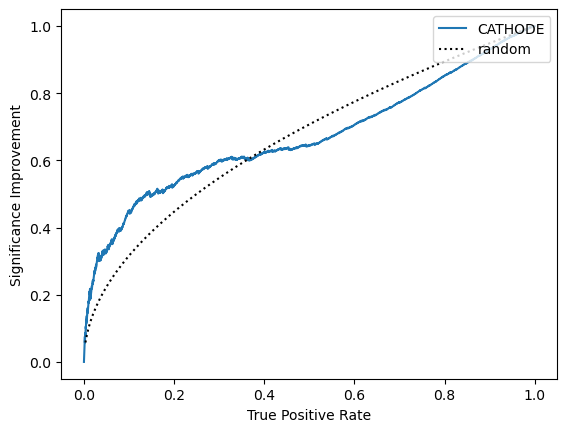

In [18]:
# now let's evaluate the signal extraction performance
#Add label 1 to innerdata_test too
print(f"innerdata_test:{innerdata_test.shape}")
#innerdata_test = np.hstack((innerdata_test, label))

X_test = inner_scaler.transform(innerdata_test[:, 1:-1])
y_test = innerdata_test[:, -1]

print(f"X_test:{X_test.shape}")
print(f"X_test:\n{X_test[:3]}")
print(f"y_test:{y_test.shape}")
print(f"y_test:\n{y_test[:3]}")

preds_test = classifier_model.predict(X_test)
print(f"preds_test:\n{preds_test[:3]}")

with np.errstate(divide='ignore', invalid='ignore'):
    fpr, tpr, _ = roc_curve(y_test, preds_test)
    print(fpr,tpr)
    sic = tpr / np.sqrt(fpr)

    random_tpr = np.linspace(0, 1, 300)
    random_sic = random_tpr / np.sqrt(random_tpr)

plt.plot(tpr, sic, label="CATHODE")
plt.plot(random_tpr, random_sic, "k:", label="random")
plt.xlabel("True Positive Rate")
plt.ylabel("Significance Improvement")
plt.legend(loc="upper right")
plt.show()